In [46]:
import keras
from keras.models import Sequential
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.optimizers import Adam

In [47]:
#Instalasi dan Setup API Kaggle
!pip install -q kaggle

In [48]:
import os
os.environ["KAGGLE_USERNAME"] = "ayusukmawatisajida" # Ganti dengan username Kaggle Anda
os.environ["KAGGLE_KEY"] = "55f9a6ab393d3baf987d474a5963e7ca" # Ganti dengan key yang ada di kaggle.json

In [52]:
!kaggle datasets download -d ayusukmawatisajida/deeplearning-multilabel-skincare

Dataset URL: https://www.kaggle.com/datasets/ayusukmawatisajida/deeplearning-multilabel-skincare
License(s): CC0-1.0
deeplearning-multilabel-skincare.zip: Skipping, found more recently modified local copy (use --force to force download)


In [53]:
# prompt: unzip file deeplearning-multilabel-skincare.zip

!unzip deeplearning-multilabel-skincare.zip

Archive:  deeplearning-multilabel-skincare.zip
replace DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar001.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar002.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar003.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar004.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar005.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar006.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar007.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar008.jpg  
  inflating: DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gam

In [54]:
#Now let us read metadata to get our Y values (multiple lables)
df = pd.read_csv('/content/traindataset_AyuSukmawatiSajida_202255202002.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)

df = df.iloc[:2000]  #Loading only first 2000 datapoints for memory reasons
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to
#the metadata from the csv file.

          Id                                        Skincare  Deodorant  \
0  Gambar001  [ 'Deodorant', 'Toner', 'Bedak', 'Sunscreen' ]          1   
1  Gambar002                            [ 'Toner', 'Bedak' ]          0   
2  Gambar003                            [ 'Toner', 'Bedak' ]          0   
3  Gambar004               [ 'Deodorant', 'Toner', 'Bedak' ]          1   
4  Gambar005                            [ 'Toner', 'Bedak' ]          0   

   Toner  Bedak  Sunscreen  
0      1      1          1  
1      1      1          0  
2      1      1          0  
3      1      1          0  
4      1      1          0  
Index(['Id', 'Skincare', 'Deodorant', 'Toner', 'Bedak', 'Sunscreen'], dtype='object')


In [55]:
SIZE = 224
X_dataset = []
image_directory = '/content/DatasetMultilabel_AyuSukmawatiSajida_202255202002'

for i in tqdm(range(df.shape[0])):
    # Construct the image path using os.path.join for better cross-platform compatibility
    image_path = os.path.join(image_directory, df['Id'][i] + '.jpg')

    # Check if the file exists before trying to load it
    if os.path.exists(image_path):
        img = image.load_img(image_path, target_size=(SIZE, SIZE))
        img = image.img_to_array(img)
        img = img/255.
        X_dataset.append(img)
X = np.array(X_dataset)

100%|██████████| 300/300 [00:37<00:00,  7.93it/s]


In [56]:
#
print(df['Id'][200])

Gambar201


In [57]:
print(df['Skincare'][200])  #Tagged as multiple Jenis Skincare.

[ 'Deodorant', 'Toner', 'Bedak' ]


In [58]:
# Now, 'df' and 'X' should have consistent lengths
y = np.array(df.drop(['Id', 'Skincare'], axis=1))

# Proceed with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [64]:
# Konfigurasi
input_shape = (224, 224, 3)  # Ukuran gambar
# Change num_classes to 5 to match the number of target variables
num_classes = 4  # Ganti sesuai jumlah label kamu
multi_label = True  # True jika multi-label, False jika multi-class

# Load MobileNetV2 tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Bekukan base model agar tidak dilatih dulu
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan layer kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
if multi_label:
    output = Dense(num_classes, activation='sigmoid')(x)
    loss_fn = 'binary_crossentropy'
else:
    output = Dense(num_classes, activation='softmax')(x)
    loss_fn = 'categorical_crossentropy'

# Bangun model
model = Model(inputs=base_model.input, outputs=output)

# Konfigurasi
input_shape = (224, 224, 3)  # Ukuran gambar
# Change num_classes to 4 to match the number of target variables
num_classes = 4  # Ganti sesuai jumlah label kamu
multi_label = True  # True jika multi-label, False jika multi-class

# Load MobileNetV2 tanpa top layer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Bekukan base model agar tidak dilatih dulu
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan layer kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
if multi_label:
    output = Dense(num_classes, activation='sigmoid')(x)
    loss_fn = 'binary_crossentropy'
else:
    output = Dense(num_classes, activation='softmax')(x)
    loss_fn = 'categorical_crossentropy'

# Bangun model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss=loss_fn, metrics=[AUC()]) # Corrected line

# Ringkasan model
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [65]:
y = np.array(df.drop(['Id', 'Skincare'], axis=1))

# X = np.array(X_dataset) #This line is redundant as X is already calculated in prior cell

# Move the data splitting line to this cell, after resizing the images:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.1)

In [66]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - auc_2: 0.7039 - loss: 0.6541 - val_auc_2: 0.9044 - val_loss: 0.3095
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - auc_2: 0.8878 - loss: 0.3632 - val_auc_2: 0.9191 - val_loss: 0.2955
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - auc_2: 0.9299 - loss: 0.2820 - val_auc_2: 0.9156 - val_loss: 0.3036
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - auc_2: 0.9178 - loss: 0.3155 - val_auc_2: 0.9163 - val_loss: 0.3023
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - auc_2: 0.9295 - loss: 0.2972 - val_auc_2: 0.9013 - val_loss: 0.3224
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - auc_2: 0.9341 - loss: 0.2855 - val_auc_2: 0.9015 - val_loss: 0.3342
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - auc_2: 0.9389 - loss: 0.2686 - val_auc_2: 0.8972 - val_loss: 0.3281
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - auc_2: 0.9487 - loss: 0.2450 - val_auc_2: 0.8981 - val_loss: 0.3312
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - auc_2:

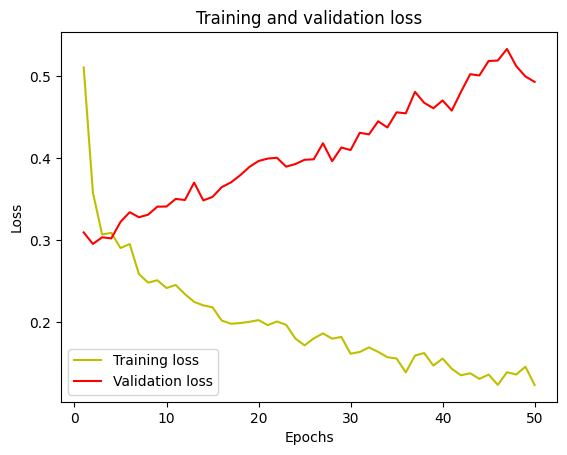

In [67]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
print(history.history.keys())

dict_keys(['auc_2', 'loss', 'val_auc_2', 'val_loss'])


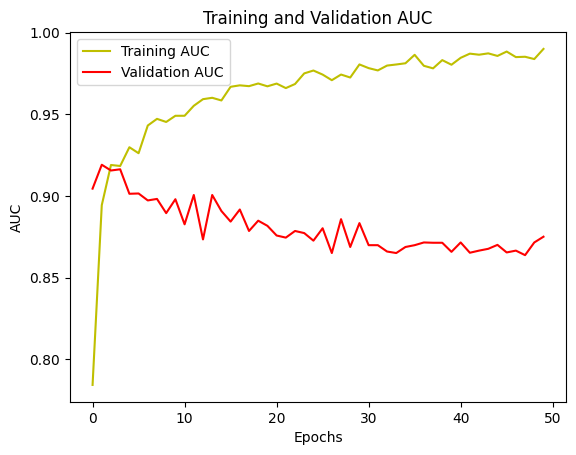

In [71]:
epochs = range(len(history.history['auc_2']))
train_auc = history.history['auc_2']
val_auc = history.history['val_auc_2']

plt.plot(epochs, train_auc, 'y', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


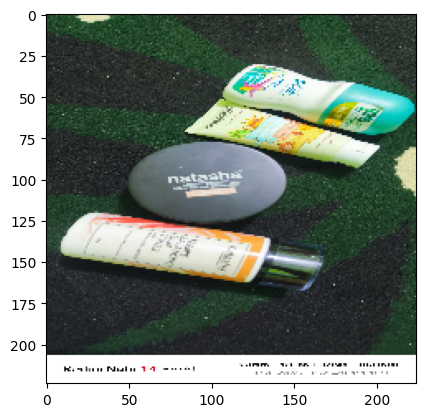

In [74]:
#Validate on an image
img = image.load_img('/content/DatasetMultilabel_AyuSukmawatiSajida_202255202002/Gambar081.jpg', target_size=(SIZE,SIZE,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[2:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

In [75]:
#Print classes and corresponding probabilities
for i in range(len(classes)):  # Change the loop to iterate over the length of 'classes'
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

Bedak (1.0)
Toner (0.999)
Deodorant (0.983)
Sunscreen (0.89)


In [76]:
###################################################

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

################################################################

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - auc_2: 0.8750 - loss: 0.4933
Accuracy =  87.5 %


In [79]:
# prompt: berikan code evaluasi model

from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert probabilities to class labels (e.g., using a threshold)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold

# Calculate and print the classification report
print(classification_report(y_test, y_pred_classes, target_names=classes))


# Calculate and print the confusion matrix (optional)
# Note: Confusion matrices are best visualized for binary or few-class problems
# For multi-label, confusion matrix for each label is more informative
for i in range(len(classes)):
  print(f"Confusion Matrix for {classes[i]}:")
  print(confusion_matrix(y_test[:,i], y_pred_classes[:,i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

   Deodorant       0.68      0.65      0.67        20
       Toner       1.00      1.00      1.00        30
       Bedak       1.00      1.00      1.00        30
   Sunscreen       0.38      0.30      0.33        10

   micro avg       0.87      0.84      0.86        90
   macro avg       0.76      0.74      0.75        90
weighted avg       0.86      0.84      0.85        90
 samples avg       0.89      0.87      0.86        90

Confusion Matrix for Deodorant:
[[ 4  6]
 [ 7 13]]
Confusion Matrix for Toner:
[[30]]
Confusion Matrix for Bedak:
[[30]]
Confusion Matrix for Sunscreen:
[[15  5]
 [ 7  3]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


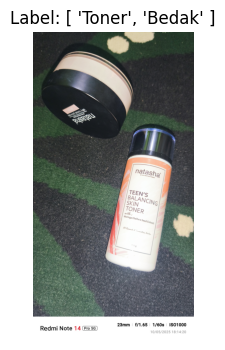

In [82]:
#Visualisasi Gambar dan Label
import os
from PIL import Image
import matplotlib.pyplot as plt

image_directory = '/content/DatasetMultilabel_AyuSukmawatiSajida_202255202002'
image_path = os.path.join(image_directory, 'Gambar002.jpg')

img = Image.open(image_path)

#Visualisasi Gambar dan Label
import os
from PIL import Image
import matplotlib.pyplot as plt

image_directory = '/content/DatasetMultilabel_AyuSukmawatiSajida_202255202002'
image_path = os.path.join(image_directory, 'Gambar005.jpg')

img = Image.open(image_path)
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"Label: {df['Skincare'][1]}") # Assuming you want the second element (index 1)
plt.axis('off')
plt.show()

In [83]:
# Cek Data Baru
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Define class_indices based on 'classes'
# Assuming 'classes' is a list of class names as defined in the previous code cells
class_indices = {class_name: index for index, class_name in enumerate(classes)}

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [84]:
def predict_new_image(image_path, model, class_indices):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)

    #For multi-label, we need to consider each class probability independently
    predicted_labels = [classes[i] for i in range(len(classes)) if prediction[0][i] > 0.5]

    # Tampilkan gambar & hasil prediksi
    plt.imshow(image.load_img(image_path))
    plt.title(f"Hasil Prediksi: {predicted_labels}")
    plt.axis("off")
    plt.show()

    return predicted_labels

In [ ]:
# Contoh penggunaan
image_path = "/content/percobaann.jpeg"
hasil_prediksi = predict_new_image(image_path, model, class_indices)

print(f"Hasil Prediksi: {hasil_prediksi}")